In [1]:
import time
import os 
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
import torchvision as tv
from torchvision import transforms
import torch.utils.data as td
from PIL import Image
from collections import OrderedDict
from matplotlib import pyplot as plt
import numpy as np

In [2]:
## Setup Directories
imageDir = os.getcwd() + '/Images/'
styleImageDir = imageDir + 'Style/'
contentImageDir = imageDir + 'Content/'

In [3]:
## Check Device 
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [4]:
## Build Dataset

class StyleTransferDataset(td.Dataset):
    def __init__(self, img_size=512):
        super(StyleTransferDataset, self).__init__()
        self.img_size = img_size
        self.style_images_dir = styleImageDir
        self.content_images_dir = contentImageDir
        self.files = os.listdir(self.style_images_dir)
        
    def __len__(self):
        return len(self.files)
    
    def __repr__(self):
        return "StyleTransferDataset(image_size={})". \
        format(self.image_size)
    
    ## Returns 
    ## [Style Image, Content Image, PreProcessed Style Image Tensor, PreProcessed Content Image Tensor, OptImage]
    def __getitem__(self, idx):

        style_img_path = os.path.join(self.style_images_dir, self.files[idx + 1])
        content_img_path = os.path.join(self.content_images_dir, self.files[idx + 1])
        
        ## Referencing Original paper's work
        pre_process = transforms.Compose([transforms.Resize(self.img_size),
                           transforms.ToTensor(),
                           transforms.Lambda(lambda x: x[torch.LongTensor([2,1,0])]), #turn to BGR
                           transforms.Normalize(mean=[0.40760392, 0.45795686, 0.48501961], #subtract imagenet mean
                                                std=[1,1,1]),
                           transforms.Lambda(lambda x: x.mul_(255)),
                          ])
        
        imgs = [Image.open(style_img_path), Image.open(content_img_path)]
        imgs_torch = [pre_process(img) for img in imgs]
        imgs_torch = [Variable(img.unsqueeze(0).to(device)) for img in imgs_torch]

        #random init
        # opt_img = Variable(torch.randn(content_image.size()).type_as(content_image.data), requires_grad=True) 

        style_image, content_image = imgs_torch
        opt_img = Variable(content_image.data.clone(), requires_grad=True)

        return imgs + [style_image, content_image, opt_img]

In [5]:
# Gram matrix and Loss
class GramMatrix(nn.Module):
    def forward(self, input):
        b,c,h,w = input.size()
        F = input.view(b, c, h*w)
        G = torch.bmm(F, F.transpose(1,2)) 
        G.div_(h*w)
        return G

class GramMSELoss(nn.Module):
    def forward(self, input, target):
        out = nn.MSELoss()(GramMatrix()(input), target)
        return(out)

In [6]:
## Layer Name to index map to easily reference features
layer_to_index = dict(r11=1, r12=3, r21=6, r22=8, r31=11, r32=13, r33=15, r34=17, r41=20, r42=22, r43=24, r44=26,
                      r51=29, r52=31, r53=33, r54=35)

In [7]:
## Neural Net
class StyleTransferNet(nn.Module):
    def __init__(self):
        super(StyleTransferNet, self).__init__()
        
        self.vgg = tv.models.vgg19(pretrained=True)  
        
        for param in self.vgg.parameters():
            param.requires_grad = False 
            
    ## Runs the forward method on pretrained vgg net and returns output features for the passed layer names
    def forward(self, x, out_layers):
        output = {}
        output[-1] = x
        num_of_layers = len(self.vgg.features)
        layers = self.vgg.features
        
        for i in range(num_of_layers):
            output[i] = layers[i](output[i-1])

        out_layer_indices = [layer_to_index[layer] for layer in out_layers]
        
        return [output[key] for key in out_layer_indices]
    

In [8]:
## Post Processing Method to get the output image from tensor 
def postProcess(tensor):
    postProcess1 = transforms.Compose([transforms.Lambda(lambda x: x.mul_(1./255)),
                               transforms.Normalize(mean=[-0.40760392, -0.45795686, -0.48501961], #add imagenet mean
                                                    std=[1,1,1]),
                               transforms.Lambda(lambda x: x[torch.LongTensor([2,1,0])]), #turn to RGB
                               ])
    postProcess2 = transforms.Compose([transforms.ToPILImage()])

    t = postProcess1(tensor)
    t[t>1] = 1    
    t[t<0] = 0
    img = postProcess2(t)
    return img

In [9]:
# compute loss functions & optimization targets
def configureLossFunctionsAndTargets(style_image, content_image, style_layers, content_layers):
    loss_layers = style_layers + content_layers
    loss_fns = [GramMSELoss()] * len(style_layers) + [nn.MSELoss()] * len(content_layers)
    loss_fns = [loss_fn.to(device) for loss_fn in loss_fns]

    #compute optimization targets
    style_targets = [GramMatrix()(A).detach() for A in net(style_image, style_layers)]
    content_targets = [A.detach() for A in net(content_image, content_layers)]
    targets = style_targets + content_targets
    
    return loss_layers, loss_fns, targets

In [10]:
## Init Net & Data
net = StyleTransferNet().to(device)
training_data = StyleTransferDataset()

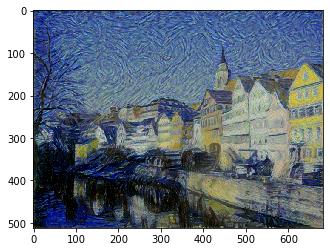

In [11]:
# configure layers & weights
style_layers = ['r11','r21','r31','r41', 'r51'] 
content_layers = ['r42']

## Configure Weights
style_weights = [1e3/n**2 for n in [64,128,256,512,512]]
content_weights = [1e-3]
weights = style_weights + content_weights

## Configure Experiment
max_iter = 500
show_iter = 10

## Run for Different Pairs
for T in training_data:
    style_image = T[2].to(device)
    content_image = T[3].to(device)
    opt_img = T[4].to(device)
    
    optimizer = optim.LBFGS([opt_img]);
    loss_layers, loss_fns, targets = configureLossFunctionsAndTargets(
        style_image, content_image, style_layers, content_layers)
    
    ## Run Net
    n_iter = [0]
    while n_iter[0] <= max_iter:

        def closure():
            optimizer.zero_grad()
            out = net(opt_img, loss_layers)
            layer_losses = [weights[a] * loss_fns[a](A, targets[a]) for a,A in enumerate(out)]
            loss = sum(layer_losses)
            loss.backward()
            n_iter[0] += 1
            return loss
    
        optimizer.step(closure)
    
    #display result
    out_img = postProcess(opt_img.data[0].cpu().squeeze())
    plt.imshow(out_img)
    # gcf().set_size_inches(10,10)